<a href="https://colab.research.google.com/github/rizkiindrawan/Tugas-Python-Image-Classification/blob/main/Tugas%20Python%20Image%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [13]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 4s 0us/step


In [14]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


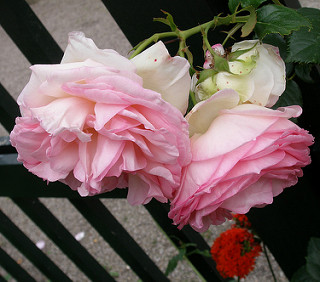

In [16]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

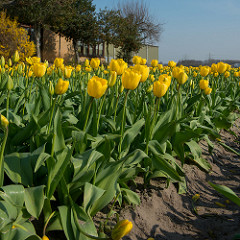

In [17]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[1]))

In [19]:
batch_size = 32
img_height = 180
img_width = 180

In [20]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [21]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [22]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


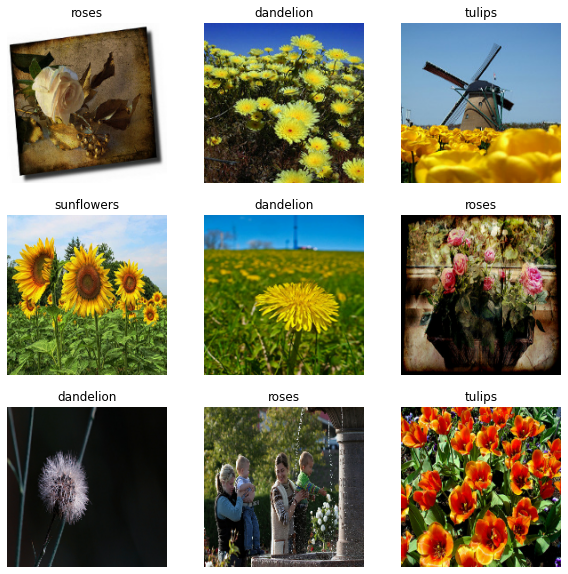

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [24]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [25]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [27]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9997713


In [28]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [31]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 87s 950ms/step - loss: 1.3310 - accuracy: 0.4349 - val_loss: 1.1282 - val_accuracy: 0.5245
Epoch 2/10
92/92 [==============================] - 86s 929ms/step - loss: 0.9907 - accuracy: 0.6046 - val_loss: 1.0129 - val_accuracy: 0.5913
Epoch 3/10
92/92 [==============================] - 86s 932ms/step - loss: 0.8253 - accuracy: 0.6839 - val_loss: 0.8879 - val_accuracy: 0.6553
Epoch 4/10
92/92 [==============================] - 86s 930ms/step - loss: 0.6372 - accuracy: 0.7732 - val_loss: 0.9022 - val_accuracy: 0.6717
Epoch 5/10
92/92 [==============================] - 86s 931ms/step - loss: 0.4136 - accuracy: 0.8559 - val_loss: 1.0721 - val_accuracy: 0.6376
Epoch 6/10
92/92 [==============================] - 86s 933ms/step - loss: 0.2789 - accuracy: 0.9053 - val_loss: 1.1949 - val_accuracy: 0.6376
Epoch 7/10
92/92 [==============================] - 90s 977ms/step - loss: 0.1679 - accuracy: 0.9482 - val_loss: 1.2967 - val_accuracy: 0.6649

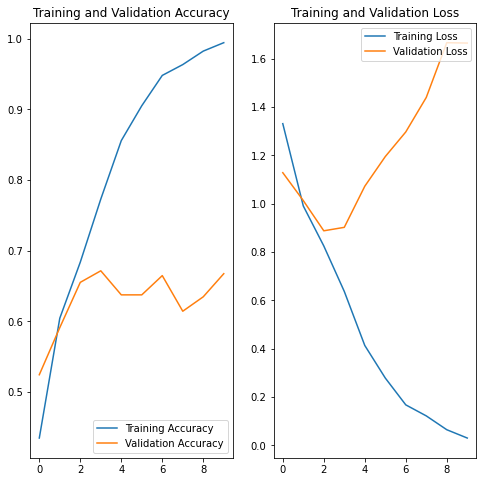

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

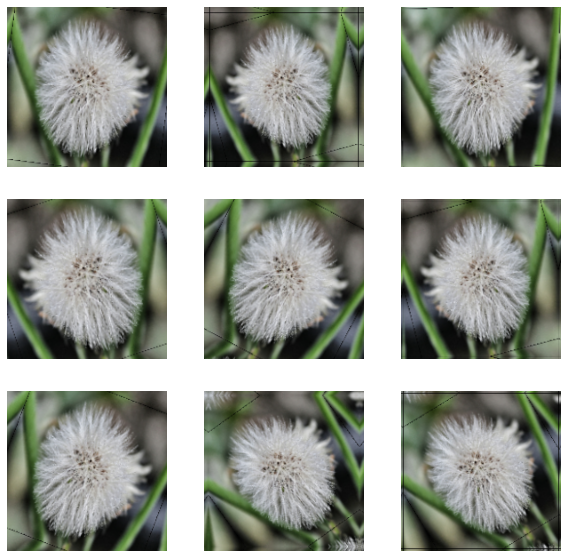

In [34]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [36]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)       

In [39]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 104s 1s/step - loss: 1.2428 - accuracy: 0.4591 - val_loss: 1.0368 - val_accuracy: 0.5804
Epoch 2/15
92/92 [==============================] - 102s 1s/step - loss: 1.0631 - accuracy: 0.5657 - val_loss: 0.9839 - val_accuracy: 0.5995
Epoch 3/15
92/92 [==============================] - 103s 1s/step - loss: 0.9487 - accuracy: 0.6342 - val_loss: 0.9404 - val_accuracy: 0.6403
Epoch 4/15
92/92 [==============================] - 103s 1s/step - loss: 0.8744 - accuracy: 0.6642 - val_loss: 0.8309 - val_accuracy: 0.6839
Epoch 5/15
92/92 [==============================] - 109s 1s/step - loss: 0.8166 - accuracy: 0.6928 - val_loss: 0.8310 - val_accuracy: 0.6935
Epoch 6/15
92/92 [==============================] - 103s 1s/step - loss: 0.7552 - accuracy: 0.7129 - val_loss: 0.7829 - val_accuracy: 0.6757
Epoch 7/15
92/92 [==============================] - 102s 1s/step - loss: 0.7328 - accuracy: 0.7200 - val_loss: 0.8591 - val_accuracy: 0.6744
Epoch 8/15
92

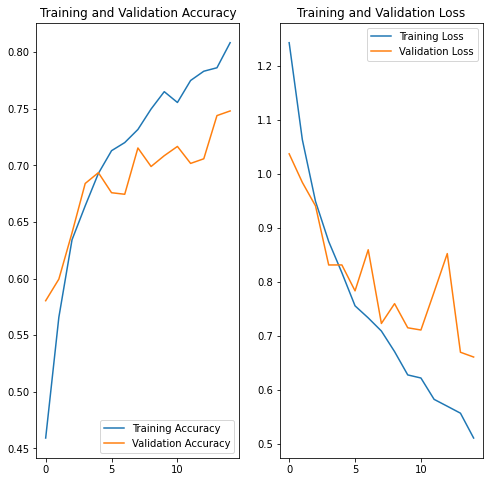

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

122880/117948 [===============================] - 0s 0us/step
This image most likely belongs to sunflowers with a 99.87 percent confidence.
